In [1]:
import torchvision
import os
from torchvision import transforms
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import torch.utils.data as Data

* 迁移学习将从源数据集中学到的知识"迁移"到⽬标数据集,微调是迁移学习的常见技巧
* 除输出层外,目标模型从源模型中复制所有模型设计及其参数,并根据⽬标数据集对这些参数进⾏微调.但是,⽬标模型的输出层需要从头开始训练
* 通常,微调参数使用较小的学习率,而从头开始训练输出层可以使用更⼤的学习率

In [2]:
data_dir = "../../../../Other/datasets/hotdog"

train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

In [3]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]

trans_ToTensor = transforms.ToTensor()
trans_ToPOLImage = transforms.ToPILImage()
trans_Resize = transforms.Resize((224, 224))  # 图片大小缩放到一致

In [4]:
img_list = []
for i in range(8):
    img_list.append(trans_ToTensor(trans_Resize(hotdogs[i])))
    img_list.append(trans_ToTensor(trans_Resize(not_hotdogs[i])))
img_batch = torch.stack(img_list, 0)
img_batch

tensor([[[[0.5961, 0.5020, 0.3373,  ..., 0.6667, 0.6667, 0.6667],
          [0.5294, 0.4824, 0.3961,  ..., 0.6667, 0.6706, 0.6706],
          [0.4314, 0.4392, 0.4431,  ..., 0.6667, 0.6745, 0.6784],
          ...,
          [0.6118, 0.5686, 0.4941,  ..., 0.5137, 0.5059, 0.5020],
          [0.6471, 0.6039, 0.5294,  ..., 0.5725, 0.5490, 0.5373],
          [0.6314, 0.6039, 0.5569,  ..., 0.6235, 0.6000, 0.5843]],

         [[0.5529, 0.4588, 0.2941,  ..., 0.6627, 0.6627, 0.6627],
          [0.4863, 0.4392, 0.3529,  ..., 0.6627, 0.6667, 0.6706],
          [0.3882, 0.3961, 0.4000,  ..., 0.6667, 0.6745, 0.6784],
          ...,
          [0.3686, 0.3373, 0.2784,  ..., 0.2667, 0.2588, 0.2549],
          [0.3725, 0.3373, 0.2745,  ..., 0.3294, 0.3020, 0.2902],
          [0.3529, 0.3294, 0.2902,  ..., 0.3843, 0.3529, 0.3333]],

         [[0.4667, 0.3725, 0.2078,  ..., 0.6824, 0.6824, 0.6824],
          [0.4078, 0.3608, 0.2745,  ..., 0.6902, 0.6941, 0.6941],
          [0.3176, 0.3255, 0.3333,  ..., 0

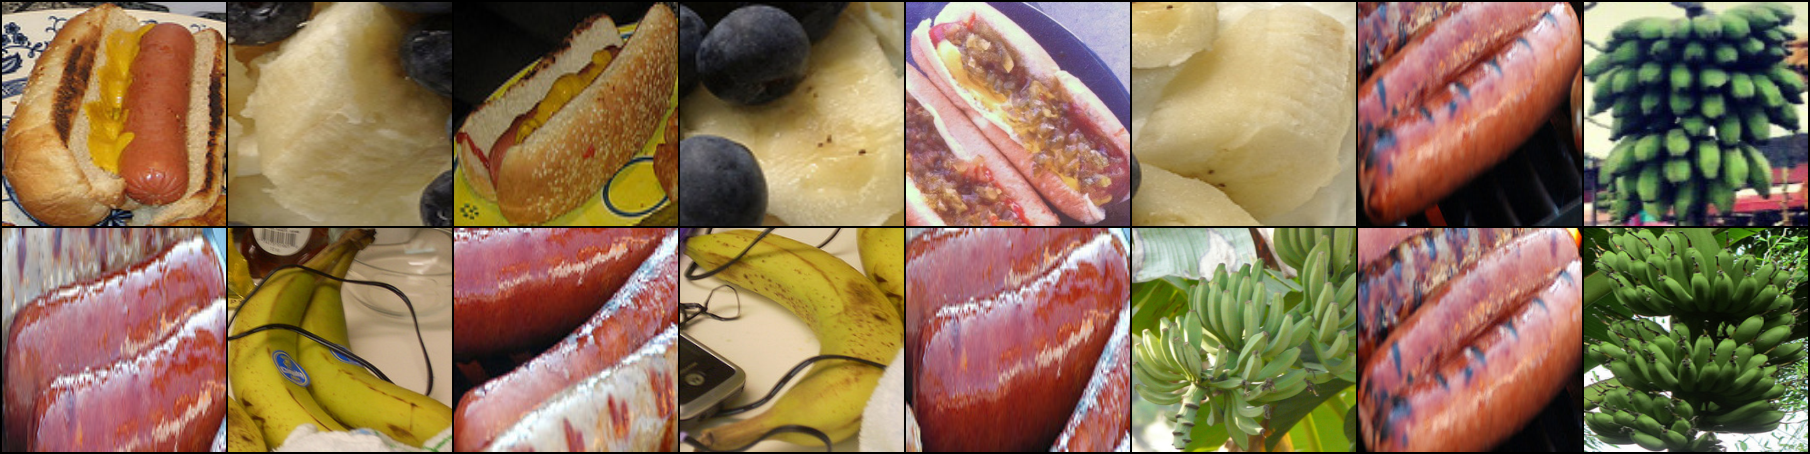

In [5]:
trans_ToPOLImage(make_grid(tensor=img_list, nrow=8))  # 热狗和非热狗图片可视化

In [6]:
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# 数据增强
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

In [7]:
# 指定pretrained=True下载预训练的模型参数
pretrained_net = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\dcdmm/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [8]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [9]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)  # 修改模型的输出层
nn.init.xavier_uniform_(finetune_net.fc.weight)

Parameter containing:
tensor([[-0.0795,  0.0987,  0.0628,  ...,  0.1080, -0.0195,  0.0007],
        [ 0.0587,  0.0081, -0.0007,  ...,  0.0938,  0.0564,  0.0662]],
       requires_grad=True)

In [10]:
from J_Template.assembly.模型训练与评估_torch.train_evaluate import Trainer


# 如果`param_group=True`,输出层中的模型参数将使用十倍的学习率
def train_fine_tuning(net, learning_rate, batch_size=64, num_epochs=5, param_group=True):
    train_iter = Data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_augs), batch_size=batch_size,
        shuffle=True)
    test_iter = Data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_augs), batch_size=batch_size)

    devices = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss = nn.CrossEntropyLoss()
    if param_group:
        params_1x = [param for name, param in net.named_parameters() if name not in ["fc.weight", "fc.bias"]]
        # 微调参数使用较小的学习率,而从头开始训练输出层可以使用更大的学习率
        trainer = torch.optim.SGD([{'params': params_1x},  # 其他层的参数将根据源模型的参数进行微调
                                   {'params': net.fc.parameters(), 'lr': learning_rate * 10}],  # 10倍学习率
                                  lr=learning_rate,  # 输出层将从头开始进行训练
                                  weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
    t_and_v = Trainer(net, trainer, loss, num_epochs, device=devices)
    history = t_and_v.train(train_iter, test_iter, verbose=5)
    return history


history_result_fintune = train_fine_tuning(finetune_net, 5e-3)

Train Epoch: 0  [0    /2000 (0  %)]	Loss: 1.123084
Train Epoch: 0  [320  /2000 (16 %)]	Loss: 6.592154
Train Epoch: 0  [640  /2000 (31 %)]	Loss: 2.589364
Train Epoch: 0  [960  /2000 (47 %)]	Loss: 0.214825
Train Epoch: 0  [1280 /2000 (62 %)]	Loss: 0.651936
Train Epoch: 0  [1600 /2000 (78 %)]	Loss: 0.346998
Train Epoch: 0  [1920 /2000 (94 %)]	Loss: 0.255615
Train Epoch: 0  [2000 /2000 (100%)]	Loss: 0.762945
----------------------------------------------------------------------------------------------------
Train Epoch: 1  [0    /2000 (0  %)]	Loss: 1.079984
Train Epoch: 1  [320  /2000 (16 %)]	Loss: 0.428931
Train Epoch: 1  [640  /2000 (31 %)]	Loss: 0.188817
Train Epoch: 1  [960  /2000 (47 %)]	Loss: 0.295458
Train Epoch: 1  [1280 /2000 (62 %)]	Loss: 0.163497
Train Epoch: 1  [1600 /2000 (78 %)]	Loss: 0.263871
Train Epoch: 1  [1920 /2000 (94 %)]	Loss: 0.342299
Train Epoch: 1  [2000 /2000 (100%)]	Loss: 1.045786
-----------------------------------------------------------------------------------

In [11]:
# 微调模型往往表现更好,因为它的初始参数值更有效
history_result_fintune

{'Training loss': [0.6998040676116943,
  0.9320303201675415,
  0.16826072335243225,
  0.6219018697738647,
  0.21550370752811432],
 'Validation loss': [0.7793527841567993,
  0.9682703614234924,
  0.1714458018541336,
  0.6166682243347168,
  0.2761074900627136]}

In [12]:
scratch_net = torchvision.models.resnet18(pretrained=False)
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
history_result_scratch = train_fine_tuning(scratch_net, 5e-2, num_epochs=10, param_group=False)

Train Epoch: 0  [0    /2000 (0  %)]	Loss: 0.694795
Train Epoch: 0  [320  /2000 (16 %)]	Loss: 2.833865
Train Epoch: 0  [640  /2000 (31 %)]	Loss: 0.908353
Train Epoch: 0  [960  /2000 (47 %)]	Loss: 0.534904
Train Epoch: 0  [1280 /2000 (62 %)]	Loss: 0.454718
Train Epoch: 0  [1600 /2000 (78 %)]	Loss: 0.537189
Train Epoch: 0  [1920 /2000 (94 %)]	Loss: 0.367512
Train Epoch: 0  [2000 /2000 (100%)]	Loss: 0.328607
----------------------------------------------------------------------------------------------------
Train Epoch: 1  [0    /2000 (0  %)]	Loss: 0.239802
Train Epoch: 1  [320  /2000 (16 %)]	Loss: 0.420358
Train Epoch: 1  [640  /2000 (31 %)]	Loss: 0.414513
Train Epoch: 1  [960  /2000 (47 %)]	Loss: 0.533572
Train Epoch: 1  [1280 /2000 (62 %)]	Loss: 0.396330
Train Epoch: 1  [1600 /2000 (78 %)]	Loss: 0.431322
Train Epoch: 1  [1920 /2000 (94 %)]	Loss: 0.321377
Train Epoch: 1  [2000 /2000 (100%)]	Loss: 0.538935
-----------------------------------------------------------------------------------

In [13]:
history_result_scratch

{'Training loss': [0.46344512701034546,
  0.6085115075111389,
  0.42098522186279297,
  1.3960769176483154,
  0.3432171940803528,
  0.3733130991458893,
  0.41291749477386475,
  0.34600141644477844,
  0.3345719277858734,
  0.40284112095832825],
 'Validation loss': [0.4845372438430786,
  0.6936392188072205,
  0.43438655138015747,
  1.4223442077636719,
  0.36588555574417114,
  0.4156554937362671,
  0.4300632178783417,
  0.4105791747570038,
  0.3594641089439392,
  0.43625038862228394]}